# Calculate Dislocation

## Dislocation


In [2]:
import geopandas as gpd
import pandas as pd
import partisan_dislocation as pdn
import numpy as np

sample_pct = 0.07
num_dists = 15

knn = gpd.read_file(
    f"../20_intermediate_files/ohio_knn_{sample_pct:.2f}_sample_{num_dists}_dists.geojson"
)

knn = knn.to_crs(epsg=26917)

districts = {}
files = {
    "challenged": "challenged_daves",
    "housedems": "housedems_congress_11_5_21",
    "ocrc": "ocrc_09_30_21",
    "senatedems": "sendems_congress_11_10_21",
}
authors = files.keys()


titles = {
    "challenged": "Enacted Plan",
    "housedems": "House Democrats' Plan",
    "ocrc": "OCRC Plan",
    "senatedems": "Senate Democrats' Plan",
}


In [3]:


for a in authors:
    districts[a] = gpd.read_file(f"../00_source_data/round2_2021_11_22/{files[a]}.shp")
    districts[a] = districts[a].to_crs(epsg=26917)
    assert len(districts[a]) == num_dists


In [4]:
knn = knn.to_crs(epsg=26917)


In [5]:
dislocation_points = {}
dislocation_dists = {}

for a in authors:
    df = pdn.calculate_dislocation(
        knn,
        districts[a],
        knn_column="knn_shr_dem",
        dem_column="dem",
        district_id_col="DISTRICT",
    )

    df["dem_knn"] = (df["knn_shr_dem"] > 0.5).astype("int")
    df["dem_dist"] = (df["district_dem_share"] > 0.5).astype("int")

    df["party_misaligned_dem_knn_in_r_dist"] = df["dem_knn"] - df["dem_dist"]
    df["party_misaligned_binary"] = np.abs(df["party_misaligned_dem_knn_in_r_dist"])
    # df.loc[np.abs(df["district_dem_share"] - 0.5) < 0.025, "party_misaligned_binary"] = 0
    dislocation_points[a] = df


## Binary Dislocations

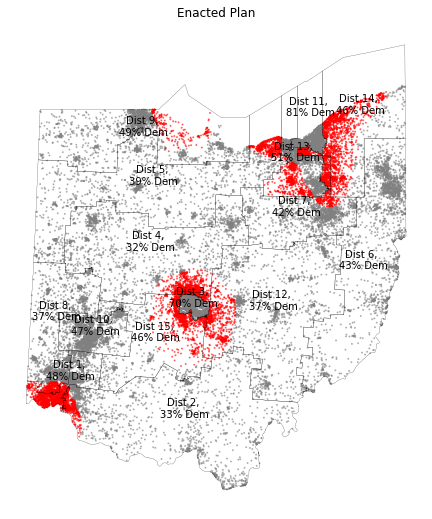

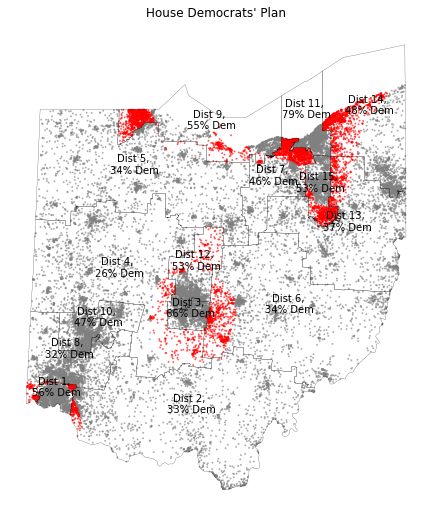

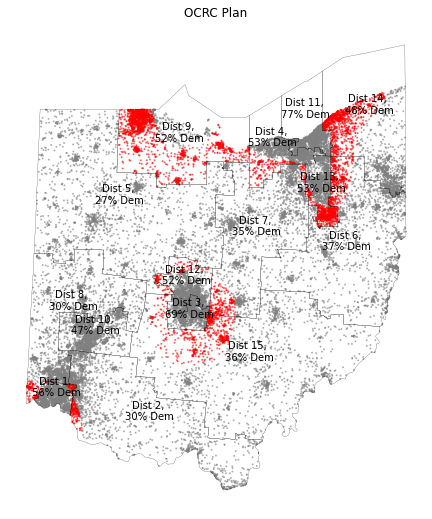

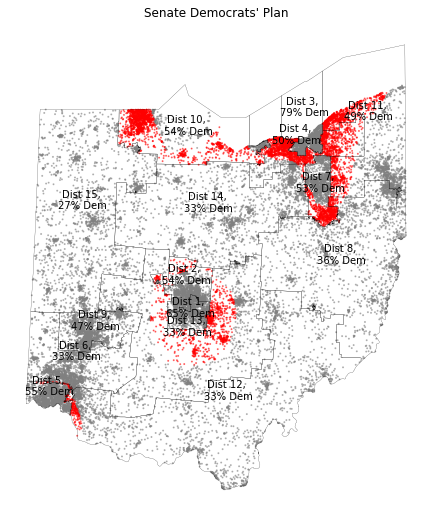

In [27]:
import matplotlib
black_red_cmap = matplotlib.colors.ListedColormap(['grey', 'red'])


for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "party_misaligned_binary",
        figsize=(9, 9),
        markersize=1,
        alpha=0.5,
        cmap = black_red_cmap
    )
    ax.set_title(titles[a])

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["party_misaligned_binary", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
            color="black"
        ),
        axis=1,
    )
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/binary_dislocation_{a}_points.png")


## Cincinnati

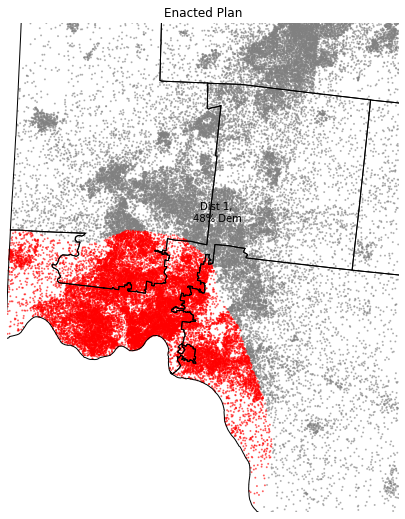

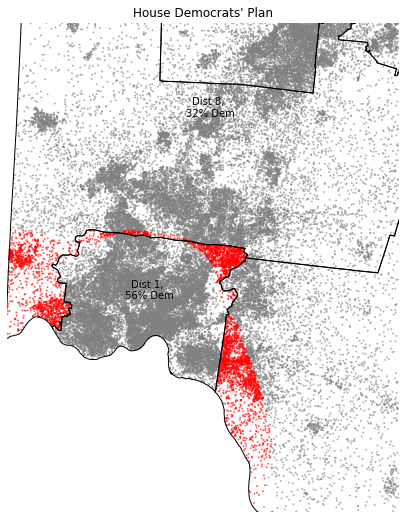

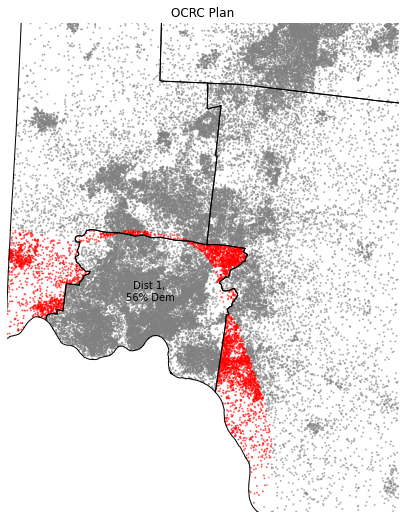

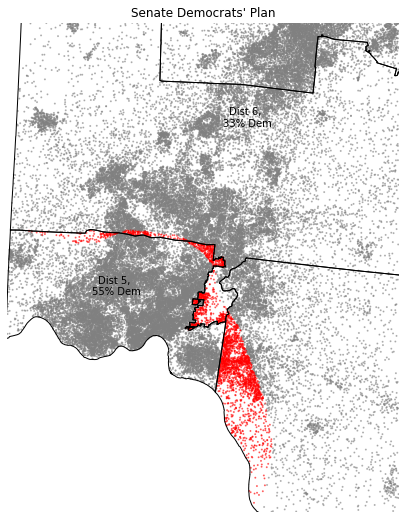

In [26]:
import matplotlib
black_red_cmap = matplotlib.colors.ListedColormap(['grey', 'red'])


for a in authors:
    df = dislocation_points[a]
    ax = df.cx[170_000:250_000, 4_300_000:4_400_000].plot(
        "party_misaligned_binary",
        figsize=(9, 9),
        markersize=1,
        alpha=0.5,
        cmap = black_red_cmap
    )
    ax.set_title(titles[a])

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["party_misaligned_binary", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
            color="black"
        ),
        axis=1,
    )
    ax.set_axis_off()
    ax.set_xlim([170_000, 250_000])
    ax.set_ylim([4_300_000, 4_400_000])
    ax.figure.savefig(f"../30_results/binary_dislocation_{a}_points_cincinnati.png")


### Distribution of Binary Dislocations Across Voters


In [7]:

import altair as alt
# alt.data_transformers.enable('data_server')
all_points = list()
for a in authors:
    df = dislocation_points[a]
    df["author"] = a
    all_points.append(df.copy())
all_points = pd.concat(all_points)
hist = all_points.groupby(["party_misaligned_binary", "author"], as_index=False)[["DISTRICT"]].count()
hist["n"] = hist["DISTRICT"]
hist["total"] = hist.groupby(["author"], as_index=False)[["DISTRICT"]].transform(np.sum)
hist["share"] = hist.n / hist.total


In [8]:
misaligned = hist[hist["party_misaligned_binary"] == 1].copy()
misaligned["author"] = misaligned.author.replace(titles)
c = (
    alt.Chart(pd.DataFrame(misaligned), title="Share of Voters Misaligned Under Different Plans")
    .mark_bar()
    .encode(
        y=alt.Y("author:N", title=""),
        x=alt.X("share:Q", title="Share of Voters Misaligned", axis=alt.Axis(format='.0%')),
    )
)
c


alt.Chart(...)

In [9]:
c.save("../30_results/distribution_of_binary_miaslignment.png")

## Absolute Misalignment by District

For map by challenged:
Voters misaligned 30%
In most misaligned district for challenged, 91% of voters are misaligned
For map by housedems:
Voters misaligned 21%
In most misaligned district for housedems, 66% of voters are misaligned
For map by ocrc:
Voters misaligned 18%
In most misaligned district for ocrc, 89% of voters are misaligned
For map by senatedems:
Voters misaligned 23%
In most misaligned district for senatedems, 94% of voters are misaligned


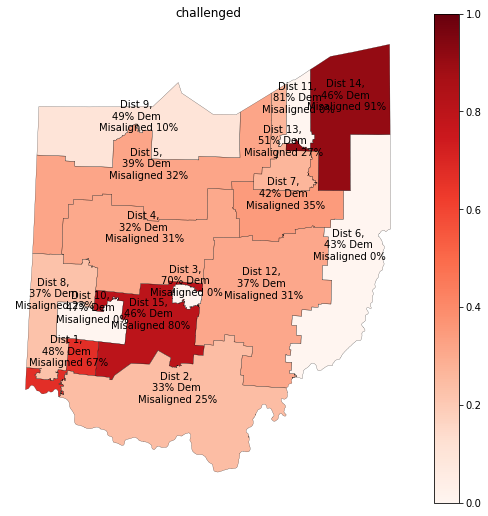

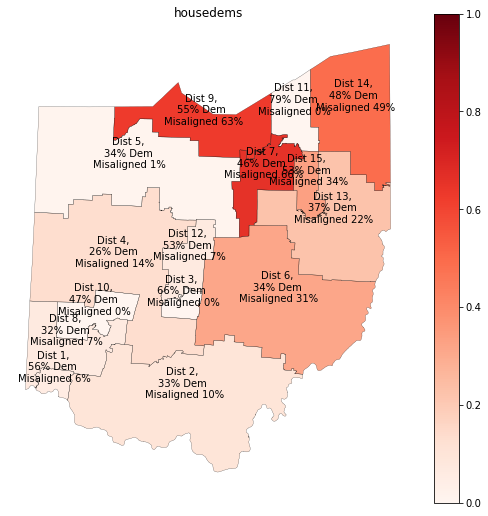

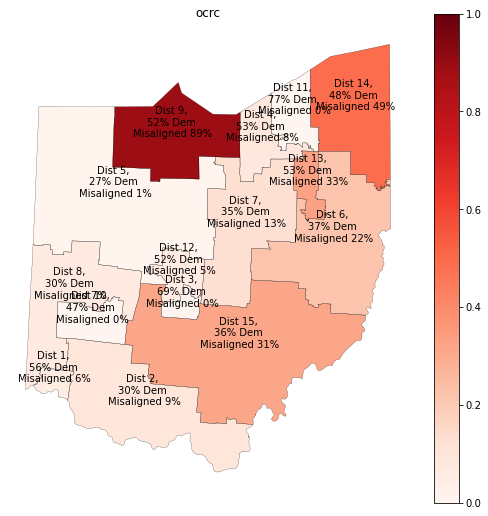

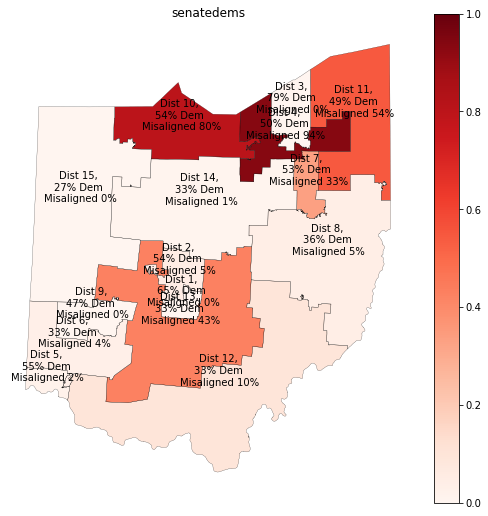

In [10]:
import pandas as pd

for a in authors:
    df = dislocation_points[a]
    print(f"For map by {a}:")
    print(
        f"Voters misaligned {df.party_misaligned_binary.mean():0.0%}"
    )

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["party_misaligned_binary", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    print(
        f"In most misaligned district for {a}, {dist.party_misaligned_binary.max():0.0%} of voters are misaligned"
    )

    ax = dist.plot(
        "party_misaligned_binary",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=1,
    )
    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem \nMisaligned {x["party_misaligned_binary"]:.0%}',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    dist.boundary.plot(edgecolor="black", ax=ax, linewidth=0.2)
    ax.set_title(a)
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/misalignment_{a}_districts.png")


## Signed Dislocation

KeyError: "Columns not found: 'abs_partisan_dislocation'"

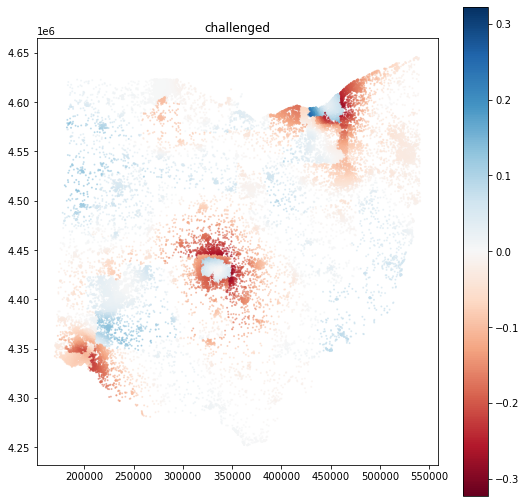

In [11]:

# Get extreme values
pd_max = 0
pd_min = 0
for a in authors:
    if candidate_max := df.partisan_dislocation.max():
        pd_max = candidate_max
    if candidate_min := df.partisan_dislocation.min():
        pd_min = candidate_min

limit = max([np.abs(pd_max), np.abs(pd_min)])

# Plot
for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "partisan_dislocation",
        cmap="RdBu",
        legend=True,
        figsize=(9, 9),
        vmin=-limit,
        vmax=limit,
        markersize=1,
        alpha=0.5,
    )
    ax.set_title(a)


    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.figure.savefig(f"../30_results/{a}_signed_dislocation.png")
    


In [ ]:
for a in authors:
    m = (
        dislocation_points[a][["partisan_dislocation", "geometry"]]
        .sample(frac=0.1)
        .explore("partisan_dislocation", cmap="RdBu", vmin=-0.35, vmax=0.35)
    )
    m.save(f"../20_intermediate_files/interactive_folium_map_{a}.html")
